# MODELING

## 1. Import Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.metrics
from matplotlib import colormaps
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

random_seed = 33
np.random.seed(random_seed)

import time

## 2. Load Files

In [2]:
df = pd.read_csv('../data/interim/online_retail_unscaled.csv')  # No outliers, unscaled.
df_scaled = pd.read_csv('../data/processed/online_retail_preprocessed.csv') # 
df_non_ol = pd.read_csv('../data/interim/online_retail_EDA.csv')
df_m_ol = pd.read_csv('../data/interim/online_retail_m_outliers.csv')
df_f_ol = pd.read_csv('../data/interim/online_retail_f_outliers.csv')


df_prep = df.copy()

In [3]:
df.head() 


,Frequency,Monetary,Recency
0,3,904.44,75
1,1,1757.55,18
2,1,334.40,310
3,8,2506.04,36
4,1,89.00,204


In [4]:
df_scaled.head()

,Frequency,Monetary,Recency
0,0.276110,0.136242,-0.201490
1,-0.843567,1.285555,-0.820832
2,-0.843567,-0.631719,2.351934
3,3.075301,2.293924,-0.625250
4,-0.843567,-0.962323,1.200176


In [5]:
df_non_ol.head()

,CustomerID,LastPurchaseDate,Frequency,Monetary,Recency
0,12348,2011-09-25,3,904.44,75
1,12349,2011-11-21,1,1757.55,18
2,12350,2011-02-02,1,334.40,310
3,12352,2011-11-03,8,2506.04,36
4,12353,2011-05-19,1,89.00,204


In [6]:
X = df.to_numpy()
X_scaled = df_scaled.to_numpy()

## 3. Modeling

Before diving in to the actual modeling, perform a hyperparameter optimization to determine the best parameters for the model.



###     3.1 GridSearchCV

In [7]:

sil_scores = []

In [8]:
# param_grid = {
#     'n_clusters': np.arange(2,11),
#     'init' : ['random', 'k-means++'],
#     'n_init' : np.arange(2,11,2),
#     'max_iter': np.arange(100,1100,100),
#     'tol': [0.0001, 0.001, 0.01, 0.1],
#     'algorithm' : ['lloyd', 'elkan']
# }

In [9]:
# import copy
# param_dist = copy.deepcopy(param_grid)


In [10]:
# param_dist = {
#     'n_clusters': np.arange(2,11),
#     'init' : ['random', 'k-means++'],
#     'n_init' : np.arange(2,11,2),
#     'max_iter': np.arange(100,1100,100),
#     'tol': [0.001, 0.001, 0.01, 0.1],
#     'algorithm' : ['lloyd', 'elkan', 'auto', 'full']
# }

In [11]:
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hyperopt import hp, tpe, rand, fmin, Trials, STATUS_OK
from sklearn.metrics import silhouette_score
import time

In [12]:
# def f_hp_optimization(x_data, cvmodel, est, params, njobs, f_scoring, fold, rand_state):
#     '''Custom function that runs GridSearchCV and RandomSearch CV using the estimator and parameter of choice.
    
#     Input: 
#         x_data - working dataset (numpy.ndarray)
#         cvmodel - CrossValidation model (sklearn.model_selection object, i.e. RandomizedSearchCV | GridSearchCV)
#         est - Estimator (sklearn object)
#         params - a dictionary of the model's parameters (dict)
#         n_jobs - no of jobs (int)
#         f_scoring - scoring metric or a custom function for clustering algorithms  (func)
#         fold - cross-validation number of folds (int)
#         rand_state - random seed (int)
#     Return:
#         Cross-validation object fitted with data (sklearn.model_selection._search.*Randomized\Grid* SearchCV object)
#     '''


#     time_start = time.time()
    
#     km = est(random_state=rand_state)
    
#     if cvmodel == GridSearchCV:
#         cv = GridSearchCV(estimator=km, param_grid=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
#     elif cvmodel == RandomizedSearchCV:
#         cv = RandomizedSearchCV(estimator=km, param_distributions=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
    
#     cv.fit(x_data)
    
#     time_end = time.time()
#     runtime = time_end - time_start
    
#     print('Model Total running time: ', runtime)
#     print("Best hyperparameters: ", cv.best_params_)
#     print('Optimal number of clusters based on parameter grid: ' + str(cv.best_params_['n_clusters']))
#     print('Best silhouette score: ', cv.best_score_)

#     return cv

### Dictionaries for model evaluation and hyperparameter tuning

Dictionary for models and their respective parameters for tuning

In [13]:
models = {
    'KMeans': {
        'model': KMeans(random_state=random_seed),
        'params': {
            'cluster__n_clusters': np.arange(2,11),
            'cluster__init' : ['random', 'k-means++'],
            'cluster__n_init' : np.arange(2,11,2),
            'cluster__max_iter': np.arange(100,1100,100),
            'cluster__tol': [0.0001, 0.001, 0.01, 0.1],
            'cluster__algorithm' : ['lloyd', 'elkan']
        }
    },

    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'params': {
            'cluster__n_clusters': np.arange(2,11),
            'cluster__metric' : [ 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'], # Note: If linkage is “ward”, only “euclidean” is accepted. .
                                                                                  #If “precomputed”, a distance matrix is needed as input for the fit method. 
                                                                                    # precomputed removed for now bec of ValueError
            'cluster__linkage': ['complete', 'average', 'single'], # which distances to use between sets of observation. 
                            #removed 'ward' as throwing an error not accepting linkage other than euclidean. see wh
            'cluster__compute_distances' : [True, False] #(bool, def=False) Computes distances between clusters even if distance_threshold is not used. This can be used to make dendrogram visualization, but introduces a computational and memory overhead
            # Below parameters were dropped for computational efficiency
            # 'cluster__compute_full_tree' : ['auto', True, False], #By default compute_full_tree is “auto”, which is equivalent to True when distance_threshold is not None or that n_clusters is inferior to the maximum between 100 or 0.02 * n_samples. Otherwise, “auto” is equivalent to False.
            # 'cluster__distance_threshold': [0.0001, 0.001, 0.01, 0.1], #(float) The linkage distance threshold at or above which clusters will not be merged. If not None, n_clusters must be None and compute_full_tree must be True.
            
        }
    },
    # 'Affinity Propagation': {
    #     'model': AffinityPropagation(random_state=random_seed),
    #     'params': {
    #         'cluster__damping': np.arange(0.5, 1.2, 0.25),
    #         # 'cluster__max_iter': [100,200,500],
    #         # 'cluster__convergence_iter' : [ 10, 15, 20 ], 
    #         'cluster__preference' : np.arange(-50, 20, 10),
    #         # 'cluster__affinity': ['precomputed', 'euclidean']
    #     }
    # }
}

Dictionary for spaces required for SMBO using hyperopt

In [14]:
km_space = {
    'n_clusters': hp.uniformint('n_clusters', 2, 10, q=2),
    'init' : hp.choice('init', ['random', 'k-means++']),
    'n_init' : hp.uniformint('n_init', 2,10, q=10),
     'max_iter': hp.uniformint('max_iter', 100, 1000, q=100),
    'tol': hp.choice('tol', [0.0001, 0.001, 0.01, 0.1]),
    'algorithm' : hp.choice('algorithm', ['lloyd', 'elkan'])
}

In [15]:
ac_space = {
    'n_clusters': hp.uniformint('n_clusters', 2, 10, q=2),
    'metric' : hp.choice('metric', [ 'euclidean', 'l1', 'l2', 'manhattan', 'cosine']), #removed precomputed as error says Distance matrix should be square, got matrix of shape
    'linkage' : hp.choice('linkage', [ 'complete', 'average', 'single']), #removed default ward as it only accepts euclidean metric. see how this model responds
    'compute_distances': hp.choice('compute_distances', [True, False])
}

### Custom Functions for hyperparameter tuning and model optimization

Define custom GridSearch() and RandomizedSearch functions()

In [16]:
def f_hp_optimization(desiredcv, x_data, pipe, params, njobs, f_scoring, fold):
    '''Custom function that runs GridSearchCV and RandomSearch CV using the estimator and parameter of choice.
    
    Input: 
        desiredcv - CrossValidation model (sklearn.model_selection object, i.e. RandomizedSearchCV | GridSearchCV)
        x_data - working dataset (numpy.ndarray)
        pipe - defined pipeline( Pipeline object )
        
        clusermodel - Clustering algo (sklearn object)
        params - a dictionary of the model's parameters (dict)
        n_jobs - no of jobs (int)
        f_scoring - scoring metric or a custom function for clustering algorithms  (func)
        fold - cross-validation number of folds (int)
        rand_state - random seed (int)
    Return:
        Cross-validation object fitted with data (sklearn.model_selection._search.*Randomized\Grid* SearchCV object)
    '''

    cv = None
    time_start = time.time()

    
    if desiredcv == GridSearchCV:
        cv = GridSearchCV(pipe, param_grid=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
    elif desiredcv == RandomizedSearchCV:
        cv = RandomizedSearchCV(pipe,param_distributions = params, n_jobs = njobs,  scoring=f_scoring, cv=fold)  
    

    if cv!= None:
        cv.fit(x_data)
        
        time_end = time.time()
        runtime = time_end - time_start
        
        print('Model Total running time: ', runtime)
        print("Best hyperparameters: ", cv.best_params_)
        # print('Optimal number of clusters based on parameter grid: ' + str(cv.best_params_['n_clusters']))
        print('Best silhouette score: ', cv.best_score_)

    return cv

Define custom scoring function for GridSearch and Randomized Search that computes the Silhouette scores

In [17]:
def f_silhouette_score(model, X):
    labels = model.fit_predict(X)
    sil_score = sklearn.metrics.silhouette_score(X, labels) 
    sil_scores.append(sil_score )
    return sil_score

Define objective functions for Bayesian Search using SMBO technique in ** hyperopt ** package

In [18]:
def km_f_objective(space):
    kmeans = KMeans(n_clusters = space['n_clusters'], 
                    random_state=random_seed, 
                    tol= space['tol'], 
                    n_init= space['n_init'], 
                    max_iter= space['max_iter'], 
                    init= space['init'],
                    algorithm= space['algorithm']
                    )

    clusterlabels = kmeans.fit_predict(X) #
    sil_score = sklearn.metrics.silhouette_score(X, clusterlabels)
    
    return { 'loss': -(sil_score), 'status': STATUS_OK }

In [19]:
def ac_f_objective(space):
    ac = AgglomerativeClustering(n_clusters = space['n_clusters'], 
                    metric= space['metric'], 
                    linkage= space['linkage'], 
                    compute_distances = space['compute_distances']
                    )

    clusterlabels = ac.fit_predict(X) 
    
    sil_score = sklearn.metrics.silhouette_score(X, clusterlabels)
    
    return { 'loss': -(sil_score), 'status': STATUS_OK }

In [20]:
def db_f_objective(space):
    kmeans = KMeans(n_clusters = space['n_clusters'], 
                    random_state=random_seed, 
                    tol= space['tol'], 
                    n_init= space['n_init'], 
                    max_iter= space['max_iter'], 
                    init= space['init'],
                    algorithm= space['algorithm']
                    )

    clusterlabels = kmeans.fit_predict(X) #
    sil_score = sklearn.metrics.silhouette_score(X, clusterlabels)
    
    return { 'loss': -(sil_score), 'status': STATUS_OK }

### Model Evaluation Process

Main Nested Cross-Validation

In [38]:
results = {}
sil_scores = []
km_bs_params = km_gs_params = {}
ac_bs_params = ac_gs_params = {}

for model_name, model_info in models.items():
    pipeline = Pipeline(steps=[
                    ( 'scaler', StandardScaler() ),
                    ( 'cluster', model_info['model'] )
                ]
    )

    print('---------------------------------------------------')
    print(model_name, '|', model_info['model'], '|', model_info['params'] )
    print('\n')


    trials = Trials()

    match model_name:
        case 'KMeans':
            km_bs_params = model_info['params']
            km_bs_best = fmin( fn= km_f_objective,
                            space = km_space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials)
            print(km_bs_best)
            
        case 'Agglomerative':
            ac_bs_params = model_info['params']
            ac_bs_best = fmin (fn = ac_f_objective,
                               space = ac_space,
                               algo = tpe.suggest,
                               max_evals = 100,
                               trials = trials)
            print(ac_bs_best)

        # case 'DBSCAN':

        #     db_bs_best = fmin (fn = db_f_objective,
        #                        space = db_space,
        #                        algo - tpe.suggest,
        #                        max_evals = 100,
        #                        trials = trials)
        case _:
            pass #or continue


    # # Run Randomized Search using f_hp_optimization
    
    # rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
    
    #  # Run Randomized Search using f_hp_optimization

    # gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
    
    # # Bayesian Search - Use X_scaled or invoke StandardScaler() first.
    
    print('+++++++++++++++++++++++++++++++++++')
    

    # bs_best = fmin( fn = mdl_f_objective,
    #                 space = mdl_space,
    #                 algo = tpe.suggest,
    #                 max_evals = 100,
    #                 trials = trials)
                   

    
    # time_start = time.time()
    
    # cv = RandomizedSearchCV(pipeline, model_info['params'], cv=10, scoring=f_silhouette_score, n_jobs=-1)
    # cv.fit(X)
        
    # time_end = time.time()
    # runtime = time_end - time_start
        
    # print('Model Total running time: ', runtime)
    # print("Best hyperparameters: ", cv.best_params_)
    # # print('Optimal number of clusters based on parameter grid: ' + str(cv.best_params_['n_clusters']))
    # print('Best silhouette score: ', cv.best_score_)

print('After loop ', km_bs_best)
print('After loop ', ac_bs_best)

---------------------------------------------------
KMeans | KMeans(random_state=33) | {'cluster__n_clusters': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'cluster__init': ['random', 'k-means++'], 'cluster__n_init': array([ 2,  4,  6,  8, 10]), 'cluster__max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]), 'cluster__tol': [0.0001, 0.001, 0.01, 0.1], 'cluster__algorithm': ['lloyd', 'elkan']}


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:13<00:00,  7.17trial/s, best loss: -0.6748295188321979]
{'algorithm': 0, 'init': 1, 'max_iter': 797.0, 'n_clusters': 2.0, 'n_init': 4.0, 'tol': 1}
+++++++++++++++++++++++++++++++++++
---------------------------------------------------
Agglomerative | AgglomerativeClustering() | {'cluster__n_clusters': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'cluster__metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 'cluster__linkage': ['complete', 'average', 'single'], 'cluster__compute_distances': [True, False]}


100%|██████████| 100/100 [00:26<00:00,  3.81trial/s, best loss: -0.6747767864922514]
{'compute_distances': 1, 'linkage': 1, 'metric': 2, 'n_clusters': 2.0}
+++++++++++++++++++++++++++++++++++
After loop  {'algorithm': 0, 'init': 1, 'max_iter': 797.0, 'n_clusters': 2.0, 'n_init': 4.0, 'tol': 1}
After loop  {'compute_distances': 1, 'linkage': 1, 'metric': 2, 'n_clusters': 2.0}


In [40]:
km_bs_best

{'algorithm': 0,
 'init': 1,
 'max_iter': 797.0,
 'n_clusters': 2.0,
 'n_init': 4.0,
 'tol': 1}

In [42]:
km_bs_params

{'cluster__n_clusters': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'cluster__init': ['random', 'k-means++'],
 'cluster__n_init': array([ 2,  4,  6,  8, 10]),
 'cluster__max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
 'cluster__tol': [0.0001, 0.001, 0.01, 0.1],
 'cluster__algorithm': ['lloyd', 'elkan']}

In [54]:
# km_bs_best['n_clusters']
km_bs_params['cluster__n_clusters'][2.0]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
sil_scores

[]

In [23]:

    
#     # Save results
#     results.append({
#         'model': model_name,
#         'best_params': grid_search.best_params_,
#         'val_recall': val_recall,
#         'test_recall': test_recall,
#         'classification_report_val': classification_report(y_val, y_val_pred),
#         'classification_report_test': classification_report(y_test, y_test_pred)
#     })

# # Plot the test recall scores
# plt.figure(figsize=(10, 6))
# model_names = [result['model'] for result in results]
# test_recalls = [result['test_recall'] for result in results]
# plt.barh(model_names, test_recalls, color='skyblue')
# plt.xlabel('Test Recall')
# plt.title('Comparison of Test Recall for Different Models')
# plt.show()

### RandomizedSearchCV

In [24]:
# rscv = f_hp_optimization(x_data=X_scaled, cvmodel=RandomizedSearchCV, est=KMeans,  params=param_dist,  njobs= -1, f_scoring=f_silhouette_score, fold=10, rand_state=random_seed)

In [25]:
# gscv = f_hp_optimization(x_data=X_scaled, cvmodel=GridSearchCV, est=KMeans,  params=param_grid,  njobs= -1, f_scoring=f_silhouette_score, fold=10, rand_state=random_seed)

### <font color='red'>BAYESIAN SEARCH </font>

There are four parts to an optimization problem:

- Objective function: what we want to minimize (loss function)
- Domain space: values of the parameters over which to minimize the objective. Note in Bayesian Optimization, space creates a probability distribution for each of the hyperparameters. 
- Hyperparameter optimization function: constructs the surrogate function (also called response surface) and chooses next (best input) values to evaluate.
- Trials: score, parameter pairs recorded each time we evaluate the objective function

#Bayesian methods take into account the previous results to try more promising values.\
#Hyperopt is an open-source Python library for Bayesian optimization that implements SMBO using the Tree-structured Parzen Estimator.\

The differences between random search and and Sequential Model-Based Optimization is clear: random search is uninformed and therefore requires more trials to minimize the objective function. The Tree Parzen Estimator, an algorithm used for SMBO, spends more time choosing the next values, but overall requires fewer evaluations of the objective function because it is able to reason about the next values to evaluate. Over many iterations, SMBO algorithms concentrate the search around the most promising values, yielding:

Lower scores on the objective function\
Faster optimization\
https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb

In [26]:
#!pip install hyperopt

In [27]:
# from hyperopt import hp, tpe, rand, fmin, Trials, STATUS_OK

In [28]:
# km_space = {
#     'n_clusters': hp.uniformint('n_clusters', 2, 10, q=10),
#     'init' : hp.choice('init', ['random', 'k-means++']),
#     'n_init' : hp.uniformint('n_init', 2,10, q=10),
#      'max_iter': hp.uniformint('max_iter', 100, 1000, q=100),
#     'tol': hp.choice('tol', [0.0001, 0.001, 0.01, 0.1]),
#     'algorithm' : hp.choice('algorithm', ['lloyd', 'elkan'])
# }

In [29]:
# def f_km_objective(space):
#     kmeans = KMeans(n_clusters = space['n_clusters'], 
#                     random_state=random_seed, 
#                     tol= space['tol'], 
#                     n_init= space['n_init'], 
#                     max_iter= space['max_iter'], 
#                     init= space['init'],
#                     algorithm= space['algorithm']
#                     )

#     clusterlabels = kmeans.fit_predict(X_scaled)
#     sil_score = sklearn.metrics.silhouette_score(X_scaled, clusterlabels)
    
#     return { 'loss': -(sil_score), 'status': STATUS_OK }


In [30]:
# trials = Trials()
# km_bs_best = fmin( fn=f_km_objective,
#             space = km_space,
#             algo = tpe.suggest,
#             max_evals = 100,
#             trials = trials)


<font color='red'>Why should we use - for loss? Aren't we supposed to look for the highest? What does the loss (-) indicate?</font>

<font color='magenta'>
<ul>ISSUES:</ul> </font>
    <li>hp.quniform() is not working and had to use hp.uniformint() instead for parameters requiring int. https://github.com/hyperopt/hyperopt/issues/508#issuecomment-508189840</li>
    <li>KM algo no longer includes 'auto' and 'full'. Default is now 'lloyd'
    </li>https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    <li>no silhouette score for GridSearchCV so define a custom scoring function. </li> 
    https://stackoverflow.com/questions/73867399/can-gridsearchcv-be-used-for-unsupervised-learning
    


<font color='green'>
<ul>TO-READ</ul>
</font>
    <li>Interpreting Trial results</li>
    https://www.analyticsvidhya.com/blog/2020/09/alternative-hyperparameter-optimization-technique-you-need-to-know-hyperopt/



### REBUILD MODEL AND ASSESS SCORE

Find which K-cluster will give the model a good inertia score. \
<font color='yellow' size=3> <i>Note: Use the scaled data for testing the optimal K for KMeans(), as StandardScaler() will precede KMeans() in the pipeline to be defined later <i></font>

In [31]:
best_km_params = gscv.best_params_

NameError: name 'gscv' is not defined

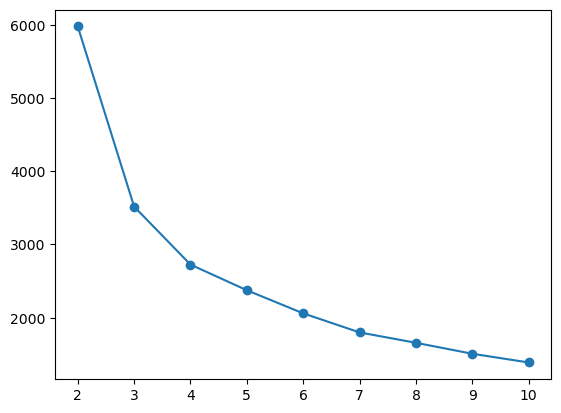

In [ ]:
# Note: Use the scaled data for this test as StandardScaler precedes KMeans in the pipeline to be defined later
from sklearn.metrics import silhouette_score

Ks = range(2,11)

inertias = []
silhouettes = {}

for k in Ks:
    kmeans = KMeans(n_clusters = k, 
                    random_state=random_seed, 
                    tol=best_km_params['tol'], 
                    n_init=best_km_params['n_init'], 
                    max_iter=best_km_params['max_iter'], 
                    init=best_km_params['init'],
                    algorithm=best_km_params['algorithm']
                    )
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes[k] = silhouette_score(X_scaled, labels)

plt.plot(Ks, inertias, '-o')
plt.show()

In [ ]:
for k, score in silhouettes.items():
    print(k ,':', score)

2 : 0.44218793754548735
3 : 0.45284160003251783
4 : 0.4126637520873019
5 : 0.409447295591825
6 : 0.36148887474507435
7 : 0.36138133652674936
8 : 0.3328718431523937
9 : 0.3343098911665606
10 : 0.3369356667905376


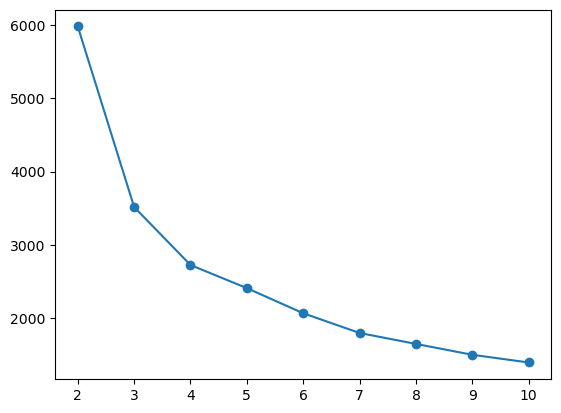

In [ ]:
# Note: Use the scaled data for this test as StandardScaler precedes KMeans in the pipeline to be defined later

Ks = range(2,11)

inertias = []

for k in Ks:
    kmeans = KMeans(n_clusters = k, random_state=seed, max_iter=1000)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(Ks, inertias, '-o')
plt.show()

K=4 is the 'Elbow' point in the figure above. Use silhouette score to further check which K-cluster is the optimal one to use. 

In [ ]:
df_scaled.head()

,Frequency,Monetary,Recency
0,0.276110,0.136242,-0.201490
1,-0.843567,1.285555,-0.820832
2,-0.843567,-0.631719,2.351934
3,3.075301,2.293924,-0.625250
4,-0.843567,-0.962323,1.200176


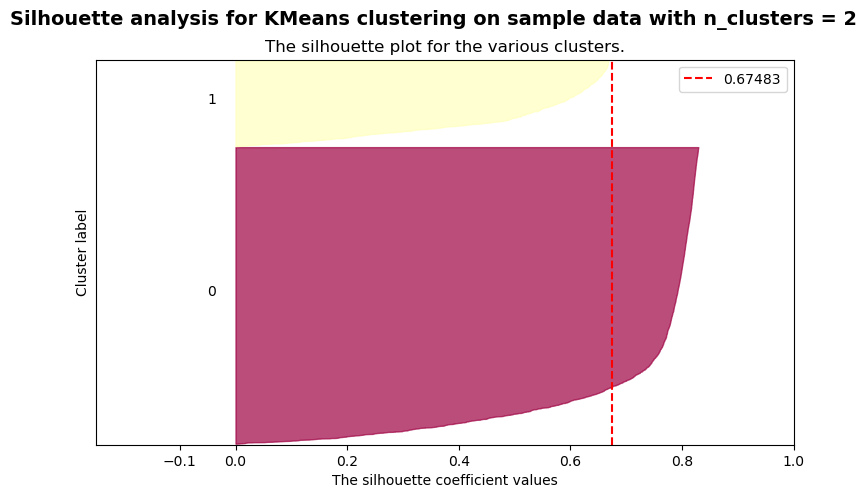

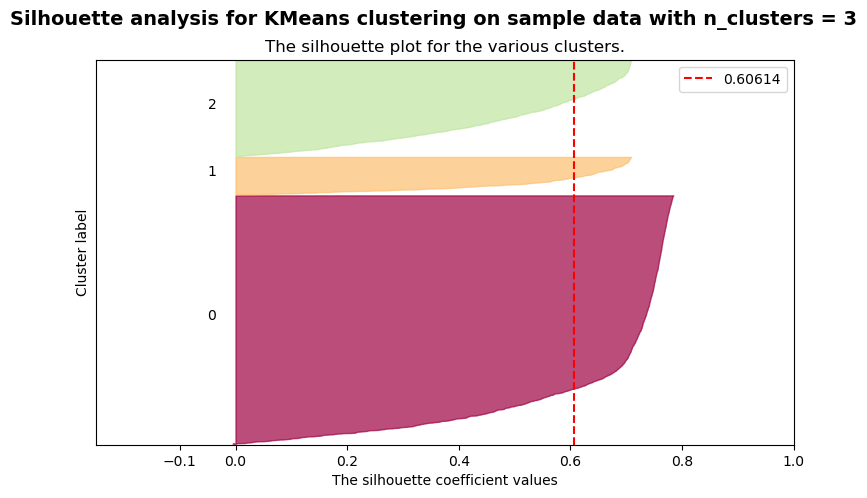

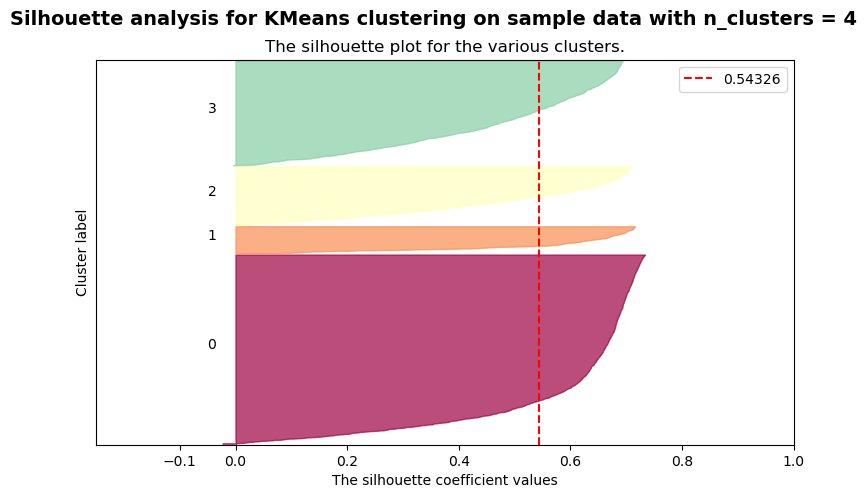

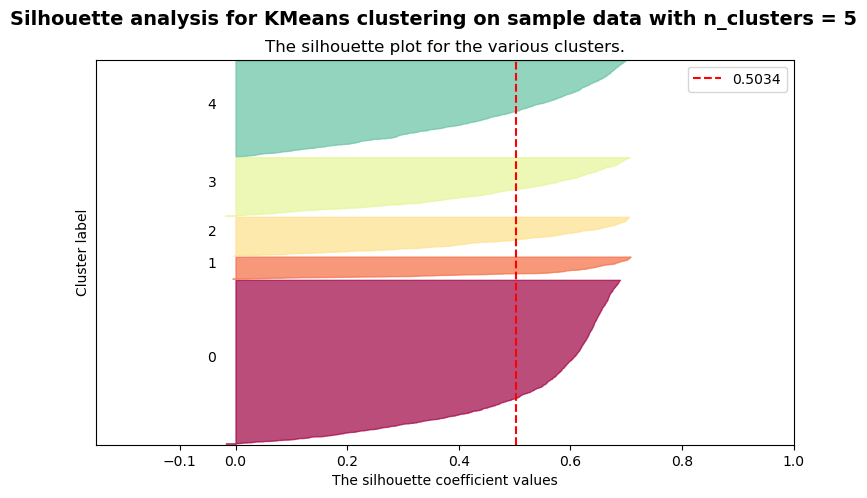

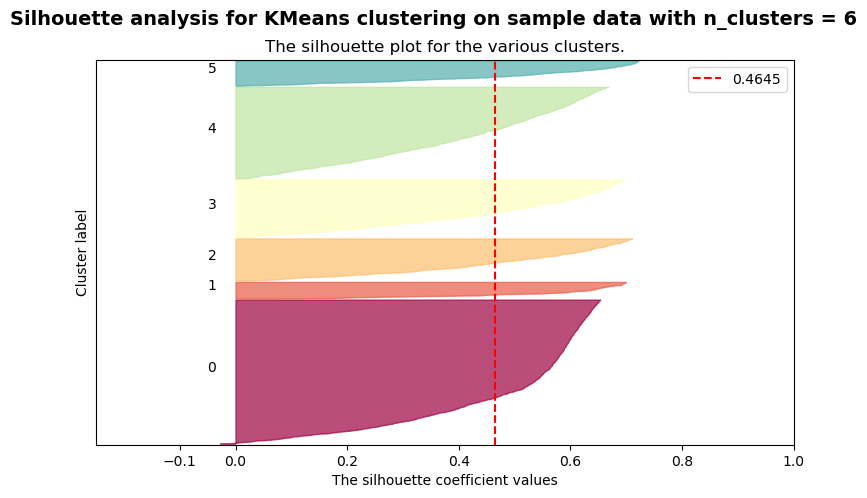

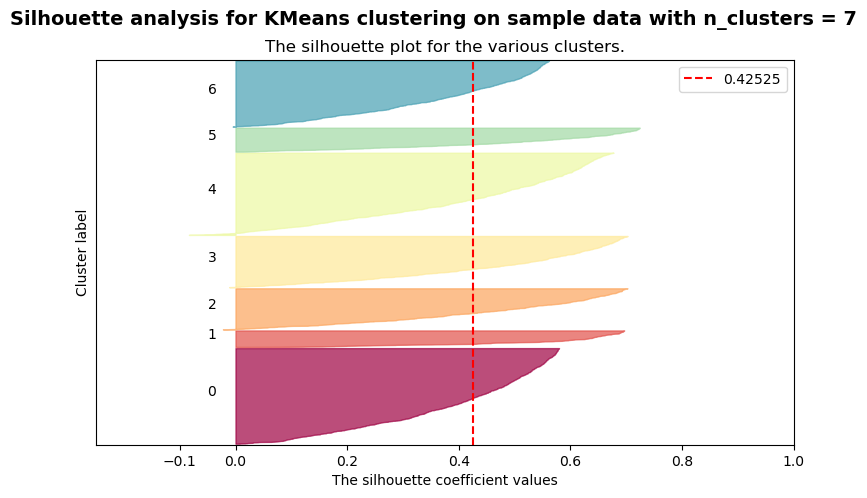

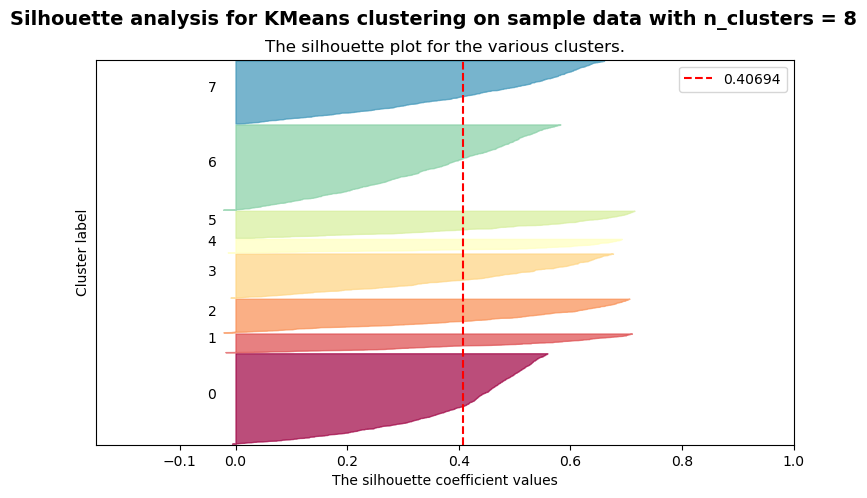

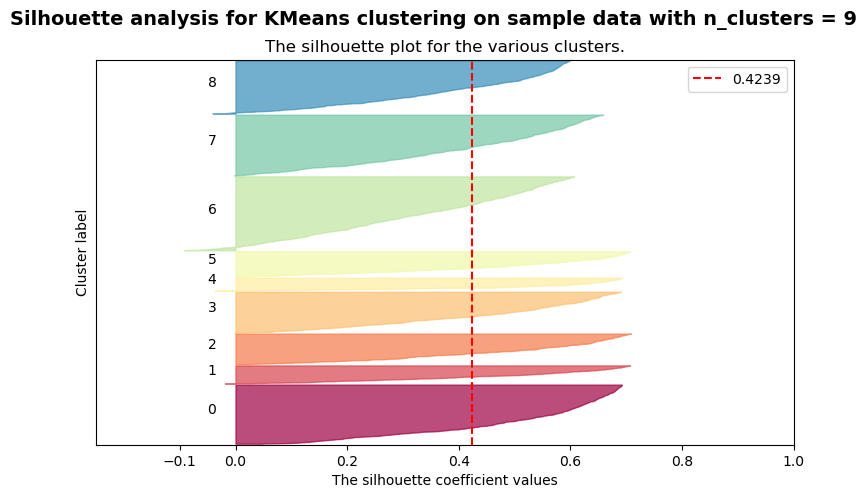

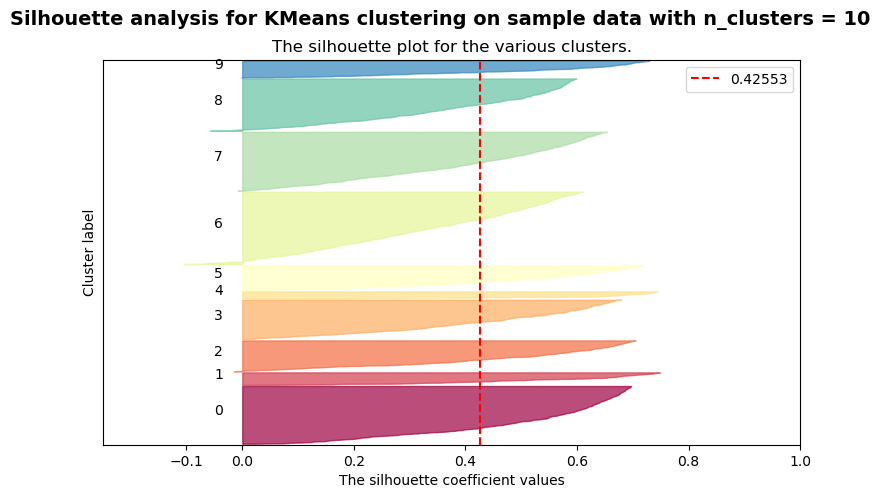

In [ ]:
# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []
avg_per_k = {}

# Iterate through Krange with variable K as before
for k in Ks:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=seed, max_iter=1000)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    avg_per_k[k] = silhouette_avg
    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = colormaps.get_cmap('Spectral')
        color = cmap(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

   
    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=silhouette_avg.round(5))

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

Based on the Silhouette plot, the best cluster K is 4. 
Q: Is this correct?

### Rebuild the model using the optimal K

In [ ]:
bestK = 4
pipe = Pipeline( [ ( 'scaler', StandardScaler() ), ('kmeans', KMeans() ) ] )
pipe.set_params(kmeans__n_clusters = bestK, kmeans__random_state = seed, kmeans__max_iter = 1000)


Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans',
                 KMeans(max_iter=1000, n_clusters=4, random_state=10))])

In [ ]:
labels = pipe.fit_predict(X)
centroids = pipe['kmeans'].cluster_centers_

In [ ]:
df_non_ol['Cluster'] = labels
df_non_ol

,CustomerID,LastPurchaseDate,Frequency,Monetary,Recency,Cluster
0,12348,2011-09-25,3,904.44,75,1
1,12349,2011-11-21,1,1757.55,18,1
2,12350,2011-02-02,1,334.40,310,2
3,12352,2011-11-03,8,2506.04,36,3
4,12353,2011-05-19,1,89.00,204,2
...,...,...,...,...,...,...
3669,18278,2011-09-27,1,173.90,73,0
3670,18280,2011-03-07,1,180.60,277,2
3671,18281,2011-06-12,1,80.82,180,2
3672,18282,2011-12-02,2,178.05,7,0


Map colors to cluster values

In [ ]:
dict_colors = { 0: '#fd4848',  #red
                1: '#fda848',  #orange
                2: '#69c641',  #green
                3: '#4196c6'   #blue
                }

label_colors = df_non_ol['Cluster'].map(dict_colors) 

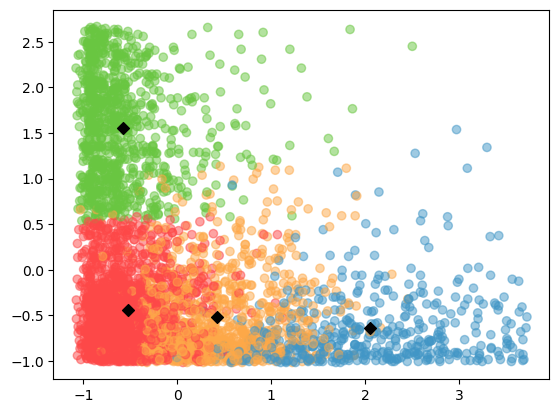

In [ ]:
f1= 1
f2 = 2

plt.scatter(X_scaled[:, f1], X_scaled[: ,f2], c=label_colors, alpha=0.5)
plt.scatter(centroids[:, f1], centroids[:, f2], marker='D', c='black')
plt.show()

Show a 3D plot

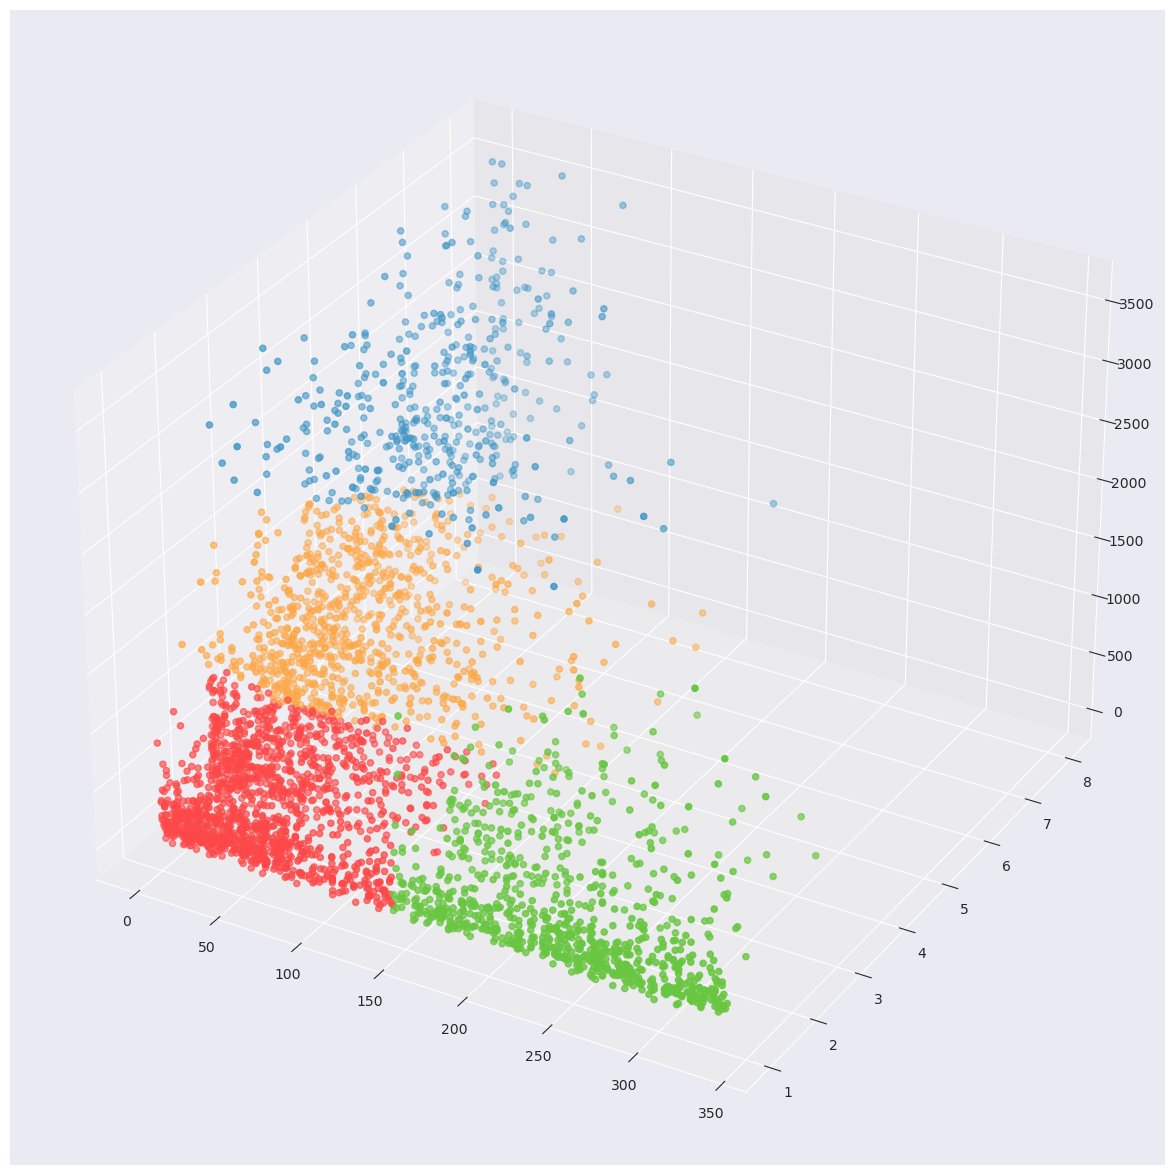

In [ ]:
sns.set_style ("darkgrid")
plt.figure (figsize = (15,15))
seaborn_plt = plt.axes (projection='3d')
seaborn_plt.scatter3D(df_non_ol.Recency, 
                      df_non_ol.Frequency, 
                      df_non_ol.Monetary,
                      c=label_colors,
                      marker='o')

Next check the distribution of labels in the cluster via barplot or violin Plot